### 데이터 구성 <br>
#### data_raw 폴더 아래에
- {name}_OHLCV.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 일별 데이터
- 첫 행 : Date, Close, High, Low, Open, Volume, Ticker
- 둘째 행 : , GLD, GLD, GLD, GLD, GLD

#### monthly_return 폴더 아래에
- {name}_monthly_return.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 월별 리턴 (월간 수익률) 데이터
- 첫 행 : Date, Monthly Return

#### data_monthly 폴더 아래에
- {name}_monthly.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 월별 가격 (월간 종가) 데이터
- 첫 행 : Date, Monthly Close

#### dividend_data 폴더 아래에
- {name}_dividends.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT 존재 (GLD는 없음)
- 배당 데이터
- 첫 행 : Date, Dividend

#### total_return 폴더 아래에
- {name}_total_return.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 배당 재투자 반영한 누적 수익률 데이터
- 첫 행 : Date, Monthly Return, Monthly Close, Dividend Yield, Total Return, Cumulative Return

# 1. 데이터 로딩 및 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os

# seaborn 스타일 설정
sns.set_style('whitegrid')
sns.set_context('talk')

# 종목 리스트
tickers = ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT', 'GLD']

# 폴더 경로
data_raw_path = './data_raw'
monthly_return_path = './monthly_return'
data_monthly_path = './data_monthly'
dividend_data_path = './dividend_data'
total_return_path = './total_return'

# 1) 일별 OHLCV 데이터 읽기
ohlcv_dfs = {}
for t in tickers:
    file = os.path.join(data_raw_path, f"{t}_OHLCV.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    ohlcv_dfs[t] = df

# 2) 월별 가격(종가) 데이터 읽기
monthly_close_dfs = {}
for t in tickers:
    file = os.path.join(data_monthly_path, f"{t}_monthly.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    monthly_close_dfs[t] = df

# 3) 월별 수익률 데이터 읽기
monthly_return_dfs = {}
for t in tickers:
    file = os.path.join(monthly_return_path, f"{t}_monthly_return.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    monthly_return_dfs[t] = df

# 4) 배당 데이터 (GLD 없음)
dividend_dfs = {}
for t in ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT']:
    file = os.path.join(dividend_data_path, f"{t}_dividends.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    dividend_dfs[t] = df

# 5) 배당 재투자 누적 수익률 데이터
total_return_dfs = {}
for t in tickers:
    file = os.path.join(total_return_path, f"{t}_total_return.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    total_return_dfs[t] = df

# 2. 포트폴리오 구성 및 계산

In [2]:
# 포트폴리오 가중치 (월별 수익률 기준)
portfolios = {
    'Stable': {'SPY': 0, 'SCHD': 0.28, 'QQQ': 0.12, 'TLT': 0.25, 'GLD': 0.35},
    'Aggressive': {'SPY': 0.4, 'SCHD': 0.25, 'QQQ': 0.25, 'TLT': 0.05, 'GLD': 0.05}
}

# 개별 종목 : SPY, SCHD, QQQ, TLT, GLD, JEPI
# 혼합 종목들은 가중 수익률 계산용 이름
mixed_tickers = {
    'SCHD7_QQQ3': {'SCHD':0.7, 'QQQ':0.3},
    'SCHD5_QQQ5': {'SCHD':0.5, 'QQQ':0.5},
    'SPY6_TLT4': {'SPY':0.6, 'TLT':0.4},
    'SPY9_TLT1': {'SPY':0.9, 'TLT':0.1},
    'SPY5_GLD4': {'SPY':0.5, 'GLD':0.5},
    'SPY9_GLD1': {'SPY':0.9, 'GLD':0.1}
}

In [3]:
# 모든 분석할 종목 리스트 (개별 + 혼합)
all_tickers = tickers + list(mixed_tickers.keys())

# 월별 수익률 데이터로 포트폴리오 및 혼합 종목 수익률 계산
def calc_mixed_monthly_return(weights_dict, monthly_return_dfs):
    # 날짜 기준 통합 인덱스 생성
    date_index = monthly_return_dfs['SPY'].index

    # 가중 평균 수익률 계산용 DataFrame
    df = pd.DataFrame(index=date_index)

    for name, weights in weights_dict.items():
        # 종목별 월별 수익률을 가져와서 가중평균 계산
        ret = pd.Series(0, index=date_index, dtype=float)
        for t, w in weights.items():
            ret += monthly_return_dfs[t]['Monthly Return'] * w
        df[name] = ret

    return df

# 혼합 종목 월별 수익률 계산
mixed_returns_df = calc_mixed_monthly_return(mixed_tickers, monthly_return_dfs)

# 개별 종목 월별 수익률 합치기
indiv_returns_df = pd.DataFrame({t: monthly_return_dfs[t]['Monthly Return'] for t in tickers})

# 전체 종목(개별+혼합) 월별 수익률 데이터프레임
all_returns_df = pd.concat([indiv_returns_df, mixed_returns_df], axis=1)

# 3. 그래프 그리기 : 버블 차트

## 3-1. Return-Risk Profile

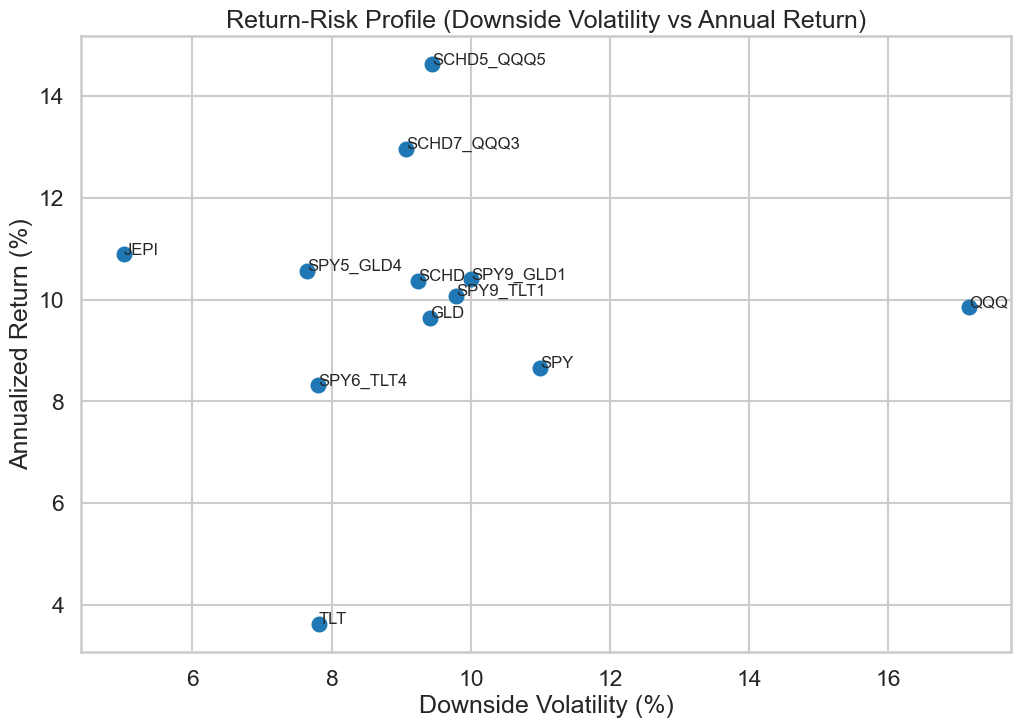

In [4]:
def annualized_return(returns):
    # 월별 수익률에서 연환산
    return ((1 + returns).prod())**(12/len(returns)) - 1

def downside_volatility(returns):
    # 음수 수익률만 표준편차, 연환산
    negative_rets = returns[returns < 0]
    return np.std(negative_rets) * np.sqrt(12) if len(negative_rets) > 0 else 0

risk_list = []
ret_list = []
tick_list = []
for t in all_tickers:
    if t in monthly_return_dfs:
        rets = monthly_return_dfs[t]['Monthly Return'].dropna()
    else:
        rets = mixed_returns_df[t].dropna()
    ann_ret = annualized_return(rets)
    d_vol = downside_volatility(rets)
    risk_list.append(d_vol*100)
    ret_list.append(ann_ret*100)
    tick_list.append(t)

plt.figure(figsize=(12,8))
plt.scatter(risk_list, ret_list, s=100)
for i, txt in enumerate(tick_list):
    plt.annotate(txt, (risk_list[i], ret_list[i]), fontsize=12)
plt.xlabel('Downside Volatility (%)')
plt.ylabel('Annualized Return (%)')
plt.title('Return-Risk Profile (Downside Volatility vs Annual Return)')
plt.show()

In [6]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 윈도우 기본 한글 폰트 경로 예시
font_path = "C:/Windows/Fonts/malgun.ttf"  # '맑은 고딕' 폰트

font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

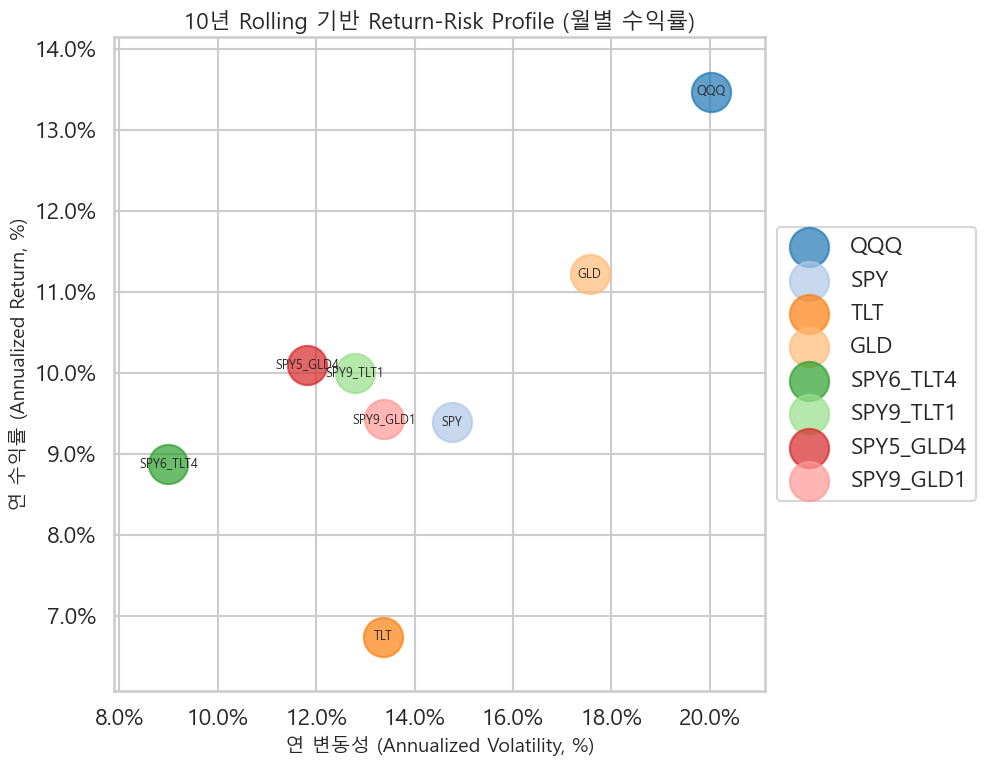

In [11]:
import math

# NaN 또는 Inf 체크하는 함수
def is_valid_num(x):
    return x is not None and not (isinstance(x, float) and (math.isnan(x) or math.isinf(x)))

# 필터링된 label 리스트 생성
valid_labels = [label for label in mean_returns.keys() 
                if is_valid_num(mean_returns[label]) and is_valid_num(mean_vols[label])]

x_vals = [mean_vols[label] for label in valid_labels]
y_vals = [mean_returns[label] for label in valid_labels]

plt.figure(figsize=(12, 8))

colors = plt.cm.tab20.colors
bubble_size = 800

for i, label in enumerate(valid_labels):
    vol = mean_vols[label]
    ret = mean_returns[label]
    plt.scatter(vol, ret, s=bubble_size, alpha=0.7, label=label, color=colors[i % len(colors)])
    plt.text(vol, ret, label, fontsize=9, ha='center', va='center')

plt.xlabel("연 변동성 (Annualized Volatility, %)", fontsize=14)
plt.ylabel("연 수익률 (Annualized Return, %)", fontsize=14)
plt.title("10년 Rolling 기반 Return-Risk Profile (월별 수익률)", fontsize=16)
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

x_margin = (max(x_vals) - min(x_vals)) * 0.1
y_margin = (max(y_vals) - min(y_vals)) * 0.1

plt.xlim(min(x_vals) - x_margin, max(x_vals) + x_margin)
plt.ylim(min(y_vals) - y_margin, max(y_vals) + y_margin)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

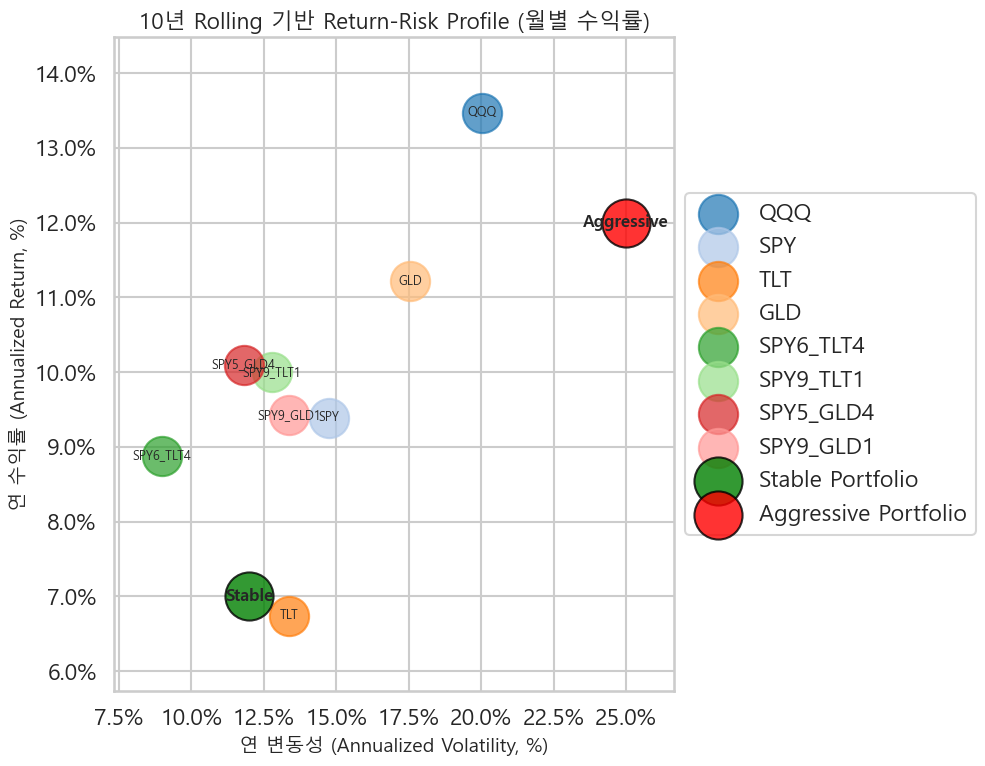

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math

# NaN 또는 Inf 체크하는 함수
def is_valid_num(x):
    return x is not None and not (isinstance(x, float) and (math.isnan(x) or math.isinf(x)))

# 기본 개별종목 필터링
valid_labels = [label for label in mean_returns.keys() 
                if is_valid_num(mean_returns[label]) and is_valid_num(mean_vols[label])]

x_vals = [mean_vols[label] for label in valid_labels]
y_vals = [mean_returns[label] for label in valid_labels]

plt.figure(figsize=(12, 8))

colors = plt.cm.tab20.colors
bubble_size = 800

# 1. 개별 종목 버블과 라벨
for i, label in enumerate(valid_labels):
    vol = mean_vols[label]
    ret = mean_returns[label]
    plt.scatter(vol, ret, s=bubble_size, alpha=0.7, label=label, color=colors[i % len(colors)])
    plt.text(vol, ret, label, fontsize=9, ha='center', va='center')

# 2. Stable, Aggressive 포트폴리오 데이터 (예시)
# mean_vols, mean_returns에 없는 별도 계산 데이터라고 가정
portfolio_data = {
    'Stable': {'vol': 0.12, 'ret': 0.07, 'color': 'green'},
    'Aggressive': {'vol': 0.25, 'ret': 0.12, 'color': 'red'}
}

# 포트폴리오 버블 크기를 좀 더 크게, 라벨은 굵게
for pname, pdata in portfolio_data.items():
    plt.scatter(pdata['vol'], pdata['ret'], s=bubble_size * 1.5, alpha=0.8, 
                label=f"{pname} Portfolio", color=pdata['color'], edgecolors='black', linewidth=1.5)
    plt.text(pdata['vol'], pdata['ret'], pname, fontsize=12, ha='center', va='center', fontweight='bold')

plt.xlabel("연 변동성 (Annualized Volatility, %)", fontsize=14)
plt.ylabel("연 수익률 (Annualized Return, %)", fontsize=14)
plt.title("10년 Rolling 기반 Return-Risk Profile (월별 수익률)", fontsize=16)
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

x_margin = (max(x_vals) - min(x_vals)) * 0.15
y_margin = (max(y_vals) - min(y_vals)) * 0.15

# 포트폴리오 데이터 포함하여 축 범위 재설정
all_x = x_vals + [pdata['vol'] for pdata in portfolio_data.values()]
all_y = y_vals + [pdata['ret'] for pdata in portfolio_data.values()]

plt.xlim(min(all_x) - x_margin, max(all_x) + x_margin)
plt.ylim(min(all_y) - y_margin, max(all_y) + y_margin)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()